In [1]:
from pathlib import Path
from typing import Union
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from fastai.data import *
from fastai.data.all import *

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# adversarial attack imports
from art.estimators.classification import KerasClassifier, TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod


import tcav as TCAV


PLOTS_DIR = Path("plots") / "adversarial"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

path = untar_data(URLs.IMAGENETTE_320)

fnames = get_image_files(path)

# these are from fastai tutorial info.  is there not an easy way to get the id -> label?
label_dict = dict(
    n01440764="tench",
    n02102040="English springer",
    n02979186="cassette player",
    n03000684="chain saw",
    n03028079="church",
    n03394916="French horn",
    n03417042="garbage truck",
    n03425413="gas pump",
    n03445777="golf ball",
    n03888257="parachute",
)

label_array = list(label_dict.values())

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)


train_folder = path / "train"


def get_all_subfolder_images(folder):
    images = []
    labels = []
    for idx, key in enumerate(label_dict.keys()):
        label_folder = folder / key
        image_paths = list(label_folder.glob("*.JPEG"))
        imgs = [tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE) for p in image_paths]
        imgs = [tf.keras.preprocessing.image.img_to_array(img) / 255 for img in imgs]
        labels_ = [idx for _ in range(len(imgs))]
        images.extend(imgs)
        labels.extend(labels_)

    assert len(images) == len(labels)
    return np.array(images), np.array(labels)


def load_data():
    images, labels = get_all_subfolder_images(path / "train")
    val_images, val_labels = get_all_subfolder_images(path / "val")

    labels_binary = tf.keras.utils.to_categorical(labels)
    val_labels_binary = tf.keras.utils.to_categorical(val_labels)
    return images, labels_binary, val_images, val_labels_binary


def train_model(images, labels_binary, val_images, val_labels_binary):

    # --------------
    
    input_layer = tf.keras.layers.Input(shape=IMG_SHAPE)
    base_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=IMG_SHAPE, weights="imagenet", input_tensor=input_layer)

    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    output = tf.keras.layers.Dense(labels_binary.shape[1], activation="softmax")(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)

    base_learning_rate = 0.0001

    loss_func = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=loss_func, metrics=["accuracy"])

    n_epochs = 100
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3),
    ]
    history = model.fit(
        x=images,
        y=labels_binary,
        epochs=n_epochs,
        batch_size=32,
        callbacks=callbacks,
        validation_data=(val_images, val_labels_binary),
    )

    return model, history


def get_adversarial_attacker(model, nb_classes, input_shape, loss_func):
    """
    nb_classes = labels_binary.shape[1]
    input_shape = images.shape[1:]
    """

    classifier = TensorFlowV2Classifier(
        model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(0, 1), loss_object=loss_func
    )
    attacker = FastGradientMethod(estimator=classifier, eps=0.1)
    return attacker


def save_model(model):
    model.save("models/latest")


def load_model_():
    return tf.keras.models.load_model("models/latest")


def generate_adversarial_images(attacker, x):
    return attacker.generate(x)


def save_images(path):
    pass


def use_tcav_for_adversarial_detection():
    pass


In [2]:
images, labels_binary, val_images, val_labels_binary = load_data()


In [3]:
model, history = train_model(images, labels_binary, val_images, val_labels_binary)
save_model(model)

attacker = get_adversarial_attacker(
    model,
    nb_classes=labels_binary.shape[1],
    input_shape=images.shape[1:],
    loss_func=tf.keras.losses.CategoricalCrossentropy(),
)

# first_n = 10
concepts = val_images
concepts_labels = val_labels_binary

x_concepts, x_concepts_subset, y_concepts, y_concepts_subset = train_test_split(concepts, concepts_labels, test_size=0.2)

x_concepts_attack = generate_adversarial_images(attacker, x_concepts)
x_concepts_subset_attack = generate_adversarial_images(attacker, x_concepts_subset)


Epoch 1/100
296/296 [==============================] - 170s 399ms/step - loss: 0.8647 - accuracy: 0.7198 - val_loss: 0.4732 - val_accuracy: 0.8436
Epoch 2/100
296/296 [==============================] - 11s 36ms/step - loss: 0.2344 - accuracy: 0.9261 - val_loss: 0.4656 - val_accuracy: 0.8543
Epoch 3/100
296/296 [==============================] - 10s 35ms/step - loss: 0.1068 - accuracy: 0.9731 - val_loss: 0.3929 - val_accuracy: 0.8726
Epoch 4/100
296/296 [==============================] - 11s 36ms/step - loss: 0.0593 - accuracy: 0.9902 - val_loss: 0.3913 - val_accuracy: 0.8775
Epoch 5/100
296/296 [==============================] - 11s 36ms/step - loss: 0.0320 - accuracy: 0.9977 - val_loss: 0.4100 - val_accuracy: 0.8772
Epoch 6/100
296/296 [==============================] - 11s 36ms/step - loss: 0.0193 - accuracy: 0.9999 - val_loss: 0.3858 - val_accuracy: 0.8879
Epoch 7/100
296/296 [==============================] - 11s 36ms/step - loss: 0.0116 - accuracy: 0.9993 - val_loss: 0.4083 - val_

In [4]:
# related to training the model
np.save("data/images", images)
np.save("data/labels_binary", labels_binary)
# related to generating adversarial
np.save("data/x_concepts", x_concepts)
np.save("data/x_concepts_subset", x_concepts_subset)
np.save("data/y_concepts", y_concepts)
np.save("data/y_concepts_subset", y_concepts_subset)
np.save("data/x_concepts_attack", x_concepts_attack)
np.save("data/x_concepts_subset_attack", x_concepts_subset_attack)

In [5]:
import matplotlib.pyplot as plt

In [6]:
plt.imshow(images[106])
label_array[labels_binary[106].argmax()]

'tench'

In [18]:
plt.imshow(x_concepts[91])
label_array[y_concepts[91].argmax()]

'English springer'

'tench'

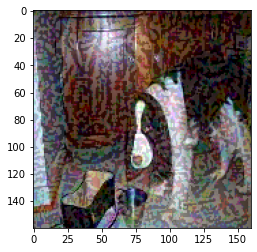

In [17]:
plt.imshow(x_concepts_attack[91])
label_array[labels_binary[91].argmax()]